# Retina Blood Vessels Detection

### Notebook's imports

In [1]:
import matplotlib.pyplot as plt
import cv2
from classifiers.classic import ClassicClassifier
from utils.confusion_matrix import ConfusionMatrix
%matplotlib inline


Bad key text.latex.preview in file C:\Users\filip\anaconda3\envs\BloodVessels\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\filip\anaconda3\envs\BloodVessels\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\filip\anaconda3\envs\BloodVessels\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpe

# Classic method

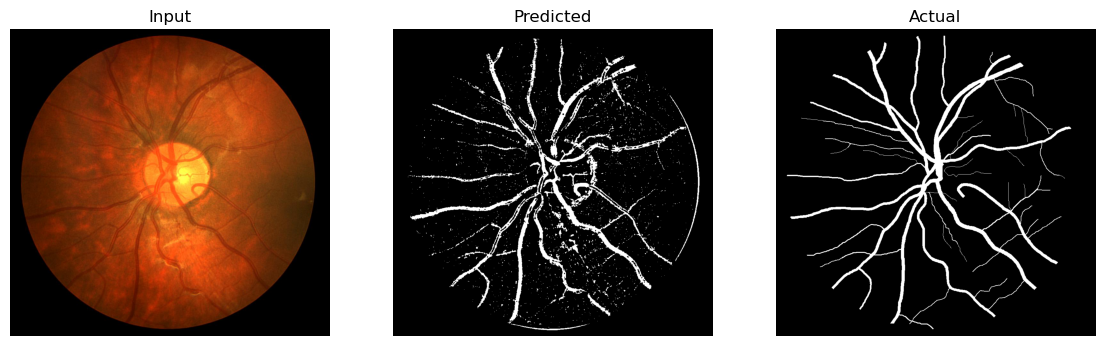

Accuracy:    0.9489948281614948
Recall:      0.6694475592434777
Specificity: 0.969952530670119



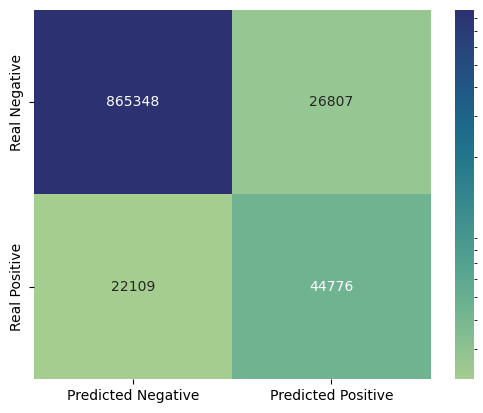

In [2]:
# Create Classifier and predict
cc = ClassicClassifier([(5, 5), (12, 12), (20, 20)], 200)
image = cv2.imread("../data/CHASED/Image_01L.jpg")
test_image = cv2.imread("../data/CHASED/Image_01L_1stHO.png", cv2.IMREAD_GRAYSCALE)
pred_image = cc.predict(image)

# Plot results
fig = plt.figure(figsize=(14, 10))
fig.add_subplot(131)
plt.title("Input")
plt.imshow(image[:,:,::-1])
plt.axis('off')

fig.add_subplot(132)
plt.title("Predicted")
plt.imshow(pred_image, cmap='gray')
plt.axis('off')

fig.add_subplot(133)
plt.title("Actual")
plt.imshow(test_image, cmap='gray')
plt.axis('off')
plt.show()

# Calculate confusion matrix
classic_cm = ConfusionMatrix(test_image.flatten(), pred_image.flatten())
print(classic_cm)
classic_cm.heatmap()